In [57]:
import numpy as np
import pylab as plt
import swyft
from swyft import utils
import torch
%load_ext autoreload
%autoreload 2
swyft.set_verbosity(5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
DEVICE = 'cuda:0'

In [40]:
def model(params, sigma = .1):
    z = np.array(list(params.values()))
    x = np.abs(z-0.5)*2  # 0 ... 1
    return dict(x=x)

In [41]:
def noise(obs, params, sigma = 0.1):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [42]:
zdim=2
params = ["z"+str(i) for i in range(zdim)]
par0 = {k: 0.25 for k in params}
obs0 = noise(model(par0), par0)
obs1=model(par0)  # Asimov data

In [43]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in params})

In [44]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 1000, Nmax=20000)

Creating new cache.


In [45]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

NRE round: R = 1
Number of training samples is N_R = 1000
Additional simulations are required after growing the cache.
Simulate:   8%|▊         | 78/1039 [00:00<00:01, 771.38it/s]

  adding 1039 new samples to simulator cache.


Simulate: 100%|██████████| 1039/1039 [00:01<00:00, 729.66it/s]
Starting neural network training.
Entering trainloop
lr: 0.001
validation loss = 2.66
validation loss = 2.037
validation loss = 1.708
validation loss = 1.754
lr: 0.0001
validation loss = 1.693
validation loss = 1.689
validation loss = 1.707
Train losses: [2.7521137122450203, 2.4294496569140205, 2.0094948513754485, 1.8326802705896312, 1.8136055099553074]
Valid losses: [2.660320440928141, 2.0371831258138022, 1.7075202862421672, 1.6926545302073162, 1.6893549760182698]
Finished trainloop.
constr_prior_R : prior_R volume = 0.9686 : 1
Volume converged.


In [46]:
samples = s.marginals(obs1, 10000)

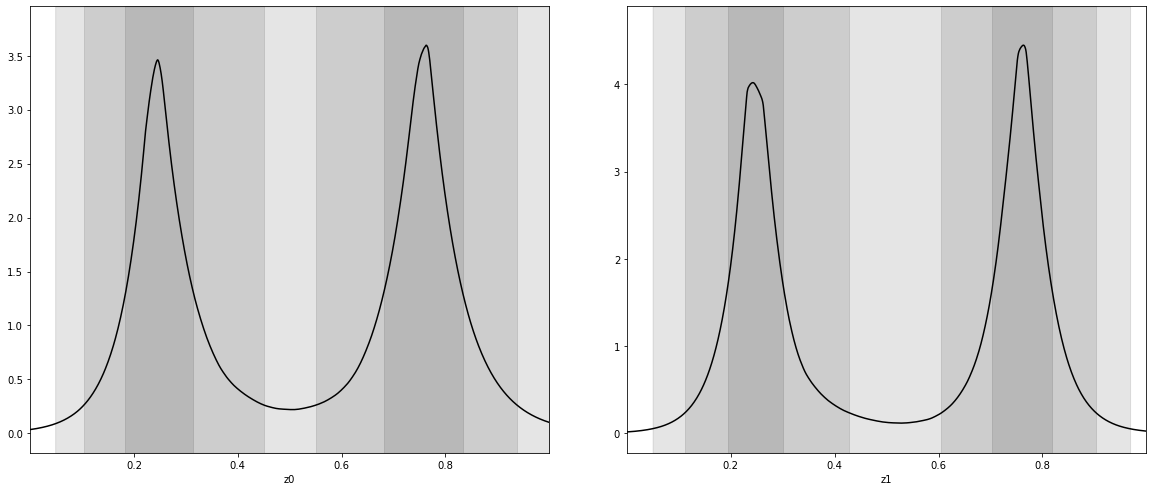

In [47]:
swyft.plot.plot1d(samples, params, figsize = (20, 8), ncol = 2, grid_interpolate = True)

In [48]:
indices = s.cache.sample(s._history[-1]['constr_prior'], 1)
points = swyft.Points(indices, s._cache, s._noise)

In [66]:
utils.estimate_coverage(s.marginals, points, nrounds = 100)

{'z0': [0.675, 1.0, 1.0], 'z1': [0.77, 0.99, 1.0]}